In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import layers, models, optimizers, utils, regularizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
assert(tf.test.gpu_device_name())

2022-04-14 15:00:55.692245: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 15:00:55.816922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 15:00:55.965124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 15:00:55.965462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
'''
    Cria uma função (int_func) que transforma cada string num inteiro. numpy.vectorize aplica essa função elemento por elemento
'''

int_func=lambda x: int(x)
vint_func=np.vectorize(int_func)

In [5]:
'''
    Cria uma função (ord_func) que transforma cada string num inteiro. numpy.vectorize aplica essa função elemento por elemento
'''

ord_func=lambda x: ord(x)-65 ## ATENÇÃO: veja abaixo o motivo de ter subtraído 65
vord_func=np.vectorize(ord_func)

#### Um breve interregno

Aqui faz-se necessário explicar de forma mais detalhada o motivo de subtrair 65 na função acima. De acordo com a documentação, ord(c) recebe uma string representando um único caractere Unicode e retorna um inteiro representando o código Unicode daquele caractere. 'A' tem o código 65, 'B' é 66, ... e 'Z' é 90. Assim, caso fizesse ord_func sem subtrair 65, teríamos

In [5]:
temp_func=lambda x: ord(x) 
vtemp_func=np.vectorize(temp_func)

In [6]:
temp=np.load('training_label_char.npy')
np.unique(temp)

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype='<U1')

Dados os códigos Unicode para as letras, ao converter o array acima teríamos

In [7]:
ar=vtemp_func(temp)
np.unique(ar)

array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89, 90])

Ocorre que, ao passar esse array pela função keras.util.to_categorical, esta irá criar o one-hot com 91 posições. O shape será

In [8]:
utils.to_categorical(ar).shape

(5400, 91)

Dessa forma, subtraindo 65 da função ord(c), conseguimos ter um array com shape (5400,26)

Fim do interregno

In [6]:
def load_img_array(file):
    '''
    Lê os arquivos com os arrays das imagens. Divide por 255 para normalizar, pois as imagens eram grayscale. Expande o shape do array, 
    pois o keras precisa ler as entradas com 4 dimensões (batch_shape, rows, cols, channels). 
    '''
    temp=np.load(file)
    temp=temp.astype('float32')/255
    temp=np.expand_dims(temp,axis=-1)
    
    return temp

In [7]:
def plotar_acuracia_loss(modelo,nome):
    
    epochs=range(1,len(modelo.history['accuracy'])+1)

    plt.rcParams["figure.figsize"] = (13,6)

    plt.subplot(1, 2, 1)

    plt.plot(epochs,modelo.history['accuracy'], color='orange', label='Acurácia de treino')
    plt.plot(epochs,modelo.history['val_accuracy'], 'b', label ='Acurácia de validação')
    plt.title('Acurácia de treino e validação do '+nome)
    plt.xlabel('Epochs')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(epochs,modelo.history['loss'], color='orange', label='Perda de treino')
    plt.plot(epochs,modelo.history['val_loss'], 'b', label ='Perda de validação')
    plt.title('Perda de treino e validação do '+nome)
    plt.xlabel('Epochs')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()
    


In [8]:
training_img_char=load_img_array('training_img_char.npy')
training_img_digit=load_img_array('training_img_digit.npy')
testing_img_char=load_img_array('testing_img_char.npy')
testing_img_digit=load_img_array('testing_img_digit.npy')
validation_img_char=load_img_array('validation_img_char.npy')
validation_img_digit=load_img_array('validation_img_digit.npy')

In [9]:
'''
    Lê os arquivos com os arrays dos labels. Notar que tais arrays contêm strings. Será necessário convertê-los para int usando
    a função ord(), quando o label for caractere, e int(), quando for inteiro. Cria o one-hot encode 
'''

training_label_char=utils.to_categorical(vord_func(np.load('training_label_char.npy')))
training_label_digit=utils.to_categorical(vint_func(np.load('training_label_digit.npy')))
testing_label_char=utils.to_categorical(vord_func(np.load('testing_label_char.npy')))
testing_label_digit=utils.to_categorical(vint_func(np.load('testing_label_digit.npy')))
validation_label_char=utils.to_categorical(vord_func(np.load('validation_label_char.npy')))
validation_label_digit=utils.to_categorical(vint_func(np.load('validation_label_digit.npy')))

##### Primeiro modelo para os dígitos

In [7]:
modelo1 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(10,
                activation='softmax')
])

2022-04-01 14:24:30.647296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 14:24:30.807356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 14:24:30.808203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 14:24:30.818328: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
modelo1.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
hist_modelo1=modelo1.fit(training_img_digit, training_label_digit, 
                 epochs=40,
                 batch_size=512,
                 validation_data=(validation_img_digit, validation_label_digit))

Epoch 1/40


2022-04-01 14:24:42.511579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-01 14:24:43.765118: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


15/15 [==============================] - 4s 34ms/step - loss: 2.2499 - accuracy: 0.1419 - val_loss: 2.3310 - val_accuracy: 0.0731
Epoch 2/40
15/15 [==============================] - 0s 12ms/step - loss: 2.0287 - accuracy: 0.3032 - val_loss: 1.9736 - val_accuracy: 0.2981
Epoch 3/40
15/15 [==============================] - 0s 12ms/step - loss: 1.6213 - accuracy: 0.5253 - val_loss: 1.5561 - val_accuracy: 0.5108
Epoch 4/40
15/15 [==============================] - 0s 12ms/step - loss: 1.2851 - accuracy: 0.6275 - val_loss: 1.2506 - val_accuracy: 0.6125
Epoch 5/40
15/15 [==============================] - 0s 12ms/step - loss: 0.9723 - accuracy: 0.7446 - val_loss: 1.0519 - val_accuracy: 0.6697
Epoch 6/40
15/15 [==============================] - 0s 12ms/step - loss: 0.6919 - accuracy: 0.8163 - val_loss: 1.1237 - val_accuracy: 0.6494
Epoch 7/40
15/15 [==============================] - 0s 12ms/step - loss: 0.5461 - accuracy: 0.8590 - val_loss: 0.7632 - val_accuracy: 0.8031
Epoch 8/40
15/15 [======

In [ ]:
plotar_acuracia_loss(hist_modelo1,"Modelo 1")

##### Segundo modelo para as letras

In [24]:
modelo2 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    
    layers.Dense(100,
                activation='relu'),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(100,
                activation='relu'),
    layers.Dense(26,
                activation='softmax')
])

In [25]:
modelo2.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
hist_modelo2=modelo2.fit(training_img_char, training_label_char, 
                 epochs=30,
                 batch_size=512,
                 validation_data=(validation_img_char, validation_label_char))

Epoch 1/30
11/11 [==============================] - 1s 25ms/step - loss: 3.1072 - accuracy: 0.2315 - val_loss: 3.0310 - val_accuracy: 0.2889
Epoch 2/30
11/11 [==============================] - 0s 12ms/step - loss: 2.8916 - accuracy: 0.2722 - val_loss: 2.8849 - val_accuracy: 0.2889
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 2.8204 - accuracy: 0.2722 - val_loss: 2.8516 - val_accuracy: 0.2889
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 2.7571 - accuracy: 0.2722 - val_loss: 2.7909 - val_accuracy: 0.2889
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 2.6409 - accuracy: 0.3019 - val_loss: 2.6827 - val_accuracy: 0.3396
Epoch 6/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4479 - accuracy: 0.3359 - val_loss: 2.5145 - val_accuracy: 0.3567
Epoch 7/30
11/11 [==============================] - 0s 11ms/step - loss: 2.1779 - accuracy: 0.3767 - val_loss: 2.3142 - val_accuracy: 0.3926
Epoch 8/30
11

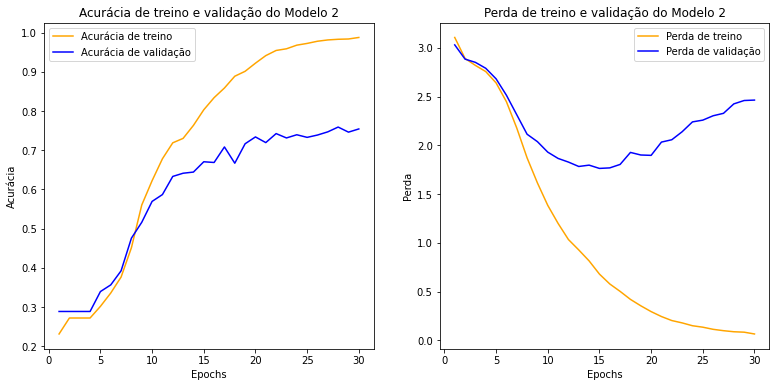

In [27]:
plotar_acuracia_loss(hist_modelo2,"Modelo 2")

Modelo para as letras usando Dropout e 3 camadas convolucionais e regularização L2

In [9]:
modelo3 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    
    layers.Dense(100,
                activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(100,
                activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(100,
                activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(26,
                activation='softmax')
])

2022-04-13 17:28:39.017356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 17:28:39.017619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 17:28:39.017792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 17:28:39.018157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 17:28:39.018349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
modelo3.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
hist_modelo3=modelo3.fit(training_img_char, training_label_char, 
                 epochs=90,
                 batch_size=256,
                 validation_data=(validation_img_char, validation_label_char))

Epoch 1/90


2022-04-13 17:28:41.772281: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-13 17:28:42.119478: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


22/22 [==============================] - 2s 21ms/step - loss: 3.4062 - accuracy: 0.1565 - val_loss: 3.2201 - val_accuracy: 0.2889
Epoch 2/90
22/22 [==============================] - 0s 8ms/step - loss: 3.1125 - accuracy: 0.2681 - val_loss: 2.9530 - val_accuracy: 0.2889
Epoch 3/90
22/22 [==============================] - 0s 8ms/step - loss: 2.8544 - accuracy: 0.2720 - val_loss: 2.7436 - val_accuracy: 0.2889
Epoch 4/90
22/22 [==============================] - 0s 8ms/step - loss: 2.6560 - accuracy: 0.2748 - val_loss: 2.5963 - val_accuracy: 0.2993
Epoch 5/90
22/22 [==============================] - 0s 8ms/step - loss: 2.4864 - accuracy: 0.3135 - val_loss: 2.5046 - val_accuracy: 0.3615
Epoch 6/90
22/22 [==============================] - 0s 8ms/step - loss: 2.3430 - accuracy: 0.3665 - val_loss: 2.3164 - val_accuracy: 0.3885
Epoch 7/90
22/22 [==============================] - 0s 8ms/step - loss: 2.1762 - accuracy: 0.4024 - val_loss: 2.1360 - val_accuracy: 0.4137
Epoch 8/90
22/22 [============

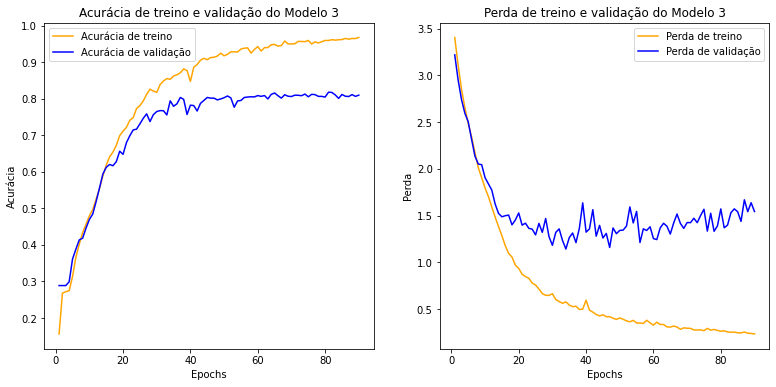

In [12]:
plotar_acuracia_loss(hist_modelo3,"Modelo 3")

Modelo com 3 camadas convolucionais, Dropout (sem regularização L2)

In [13]:
modelo4 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    
    layers.Dense(100,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(26,
                activation='softmax')
])

In [14]:
modelo4.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
hist_modelo4=modelo4.fit(training_img_char, training_label_char, 
                 epochs=90,
                 batch_size=256,
                 validation_data=(validation_img_char, validation_label_char))

Epoch 1/90
22/22 [==============================] - 1s 15ms/step - loss: 3.1403 - accuracy: 0.1478 - val_loss: 2.9717 - val_accuracy: 0.2889
Epoch 2/90
22/22 [==============================] - 0s 8ms/step - loss: 2.9226 - accuracy: 0.2676 - val_loss: 2.8477 - val_accuracy: 0.2889
Epoch 3/90
22/22 [==============================] - 0s 8ms/step - loss: 2.7919 - accuracy: 0.2694 - val_loss: 2.7216 - val_accuracy: 0.2889
Epoch 4/90
22/22 [==============================] - 0s 8ms/step - loss: 2.6269 - accuracy: 0.2735 - val_loss: 2.5395 - val_accuracy: 0.2889
Epoch 5/90
22/22 [==============================] - 0s 8ms/step - loss: 2.4536 - accuracy: 0.2974 - val_loss: 2.4454 - val_accuracy: 0.3585
Epoch 6/90
22/22 [==============================] - 0s 8ms/step - loss: 2.3258 - accuracy: 0.3474 - val_loss: 2.3712 - val_accuracy: 0.3674
Epoch 7/90
22/22 [==============================] - 0s 8ms/step - loss: 2.2160 - accuracy: 0.3693 - val_loss: 2.2214 - val_accuracy: 0.3941
Epoch 8/90
22/22 [=

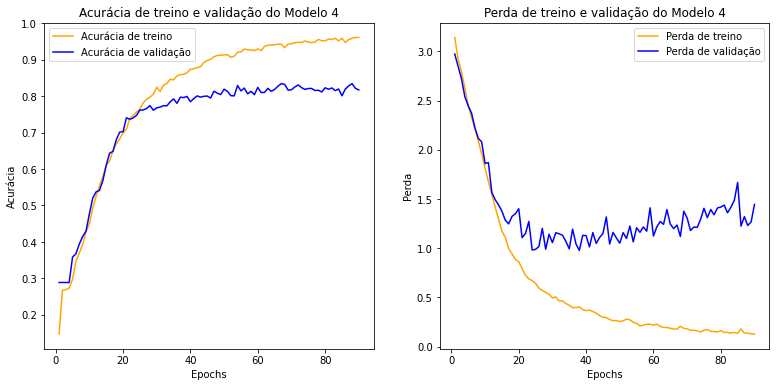

In [16]:
plotar_acuracia_loss(hist_modelo4,"Modelo 4")

Modelo 5 com 3 camadas convolucionais, Dropout e Data Augmentation

In [19]:
modelo5 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    
    layers.Dense(100,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(26,
                activation='softmax')
])

In [20]:
modelo5.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
datagen = ImageDataGenerator(
            zca_epsilon=1e-06,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            shear_range=0.2,
            horizontal_flip=True
            )

In [22]:
datagen.fit(training_img_char)

In [23]:
hist_modelo5=modelo5.fit(datagen.flow(training_img_char, training_label_char), 
                 epochs=70,
                 batch_size=256,
                 validation_data=(validation_img_char, validation_label_char))

Epoch 1/70
169/169 [==============================] - 2s 8ms/step - loss: 2.9462 - accuracy: 0.2509 - val_loss: 2.8134 - val_accuracy: 0.2889
Epoch 2/70
169/169 [==============================] - 1s 7ms/step - loss: 2.7903 - accuracy: 0.2722 - val_loss: 2.6593 - val_accuracy: 0.2889
Epoch 3/70
169/169 [==============================] - 1s 7ms/step - loss: 2.6755 - accuracy: 0.2735 - val_loss: 2.5625 - val_accuracy: 0.3241
Epoch 4/70
169/169 [==============================] - 1s 7ms/step - loss: 2.5689 - accuracy: 0.3063 - val_loss: 2.4595 - val_accuracy: 0.3537
Epoch 5/70
169/169 [==============================] - 1s 7ms/step - loss: 2.4342 - accuracy: 0.3389 - val_loss: 2.3276 - val_accuracy: 0.3663
Epoch 6/70
169/169 [==============================] - 1s 7ms/step - loss: 2.3447 - accuracy: 0.3504 - val_loss: 2.2371 - val_accuracy: 0.3711
Epoch 7/70
169/169 [==============================] - 1s 7ms/step - loss: 2.2663 - accuracy: 0.3615 - val_loss: 2.2505 - val_accuracy: 0.3841
Epoch 

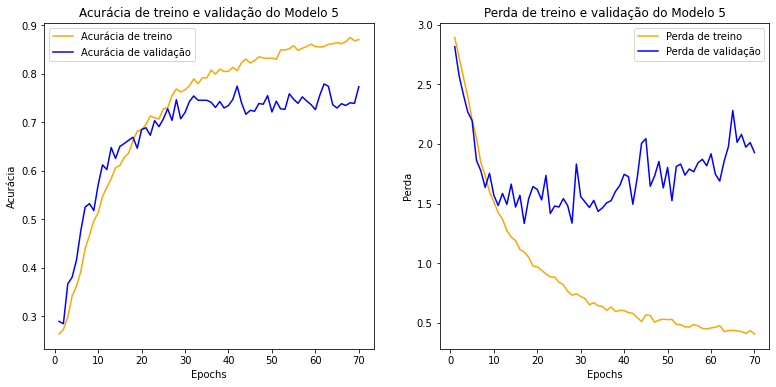

In [18]:
plotar_acuracia_loss(hist_modelo5,"Modelo 5")

Modelo 6 - 3 camadas convolucionais, Dropout e MLP com 256 unidades

In [9]:
modelo6 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    
    layers.Dense(256,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,
                activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(26,
                activation='softmax')
])

2022-04-13 20:00:04.232523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 20:00:04.232767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 20:00:04.232974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 20:00:04.233652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 20:00:04.233827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
modelo6.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
hist_modelo6=modelo6.fit(training_img_char, training_label_char, 
                 epochs=90,
                 batch_size=256,
                 validation_data=(validation_img_char, validation_label_char))

Epoch 1/90


2022-04-13 20:00:39.811209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-13 20:00:41.241643: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


22/22 [==============================] - 5s 21ms/step - loss: 2.9938 - accuracy: 0.2437 - val_loss: 2.8662 - val_accuracy: 0.2889
Epoch 2/90
22/22 [==============================] - 0s 8ms/step - loss: 2.7954 - accuracy: 0.2722 - val_loss: 2.7286 - val_accuracy: 0.2889
Epoch 3/90
22/22 [==============================] - 0s 8ms/step - loss: 2.5916 - accuracy: 0.2737 - val_loss: 2.5517 - val_accuracy: 0.2963
Epoch 4/90
22/22 [==============================] - 0s 8ms/step - loss: 2.4079 - accuracy: 0.3252 - val_loss: 2.4630 - val_accuracy: 0.3526
Epoch 5/90
22/22 [==============================] - 0s 8ms/step - loss: 2.2206 - accuracy: 0.3630 - val_loss: 2.2192 - val_accuracy: 0.3700
Epoch 6/90
22/22 [==============================] - 0s 8ms/step - loss: 1.9819 - accuracy: 0.4087 - val_loss: 2.0427 - val_accuracy: 0.4467
Epoch 7/90
22/22 [==============================] - 0s 8ms/step - loss: 1.7375 - accuracy: 0.4685 - val_loss: 1.8224 - val_accuracy: 0.4385
Epoch 8/90
22/22 [============

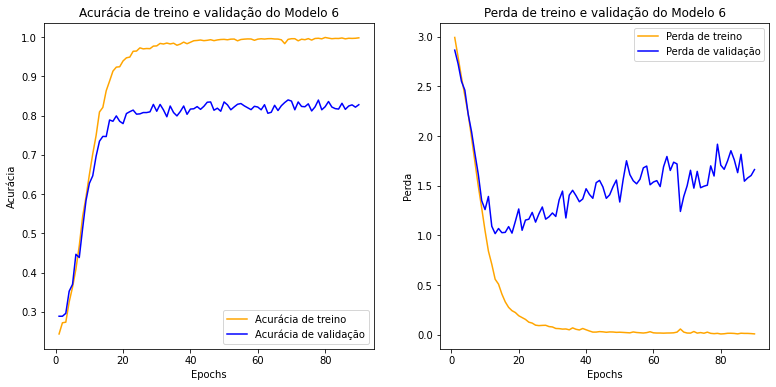

In [12]:
plotar_acuracia_loss(hist_modelo6,"Modelo 6")